# Computational Carpentry - Project
#### Group K - Julian Barth, Marin Desgeans, Lucas Eichenberger
26 september 2025


#### Part A – Data structures and functions

The goal of this part is to create a function capable of calculating the molecular mass of any molecule. For this we will first load a periodic table containing all the elements' masses.

In [7]:
import pandas as pd
import re
from collections import defaultdict

# 1. Load periodic_table.csv
df = pd.read_csv("periodic_table.csv")

We are now able to create a dictionnary where the keys are elements symbol and the values are atomic 
masses.

In [8]:
# 2. Create dictionary
atomic_masses = dict(zip(df["Symbol"], df["AtomicMass"]))

We can now write a simple function that calculates the molecular mass of a molecule. The pattern will recognise the element and capture the following number that represents the number of atom of this element in the molecule. A simple loop will then calculate the molecular mass of the molecule and return it. 

You may run the cell to verify the good usage of the function. 

In [ ]:
# 3. Create function to compute molecular mass
def molecular_mass(formula: str) -> float:
    """
    Compute molecular mass of a formula like 'H2O' or 'C6H12O6'
    """
    pattern = r"([A-Z][a-z]?)(\d*)"
    mass = 0.0
    for element, count in re.findall(pattern, formula):
        count = int(count) if count else 1
        mass += atomic_masses[element] * count
    return mass

# Example usage
print(molecular_mass("H2O"))  #18.015 g/mol
print(molecular_mass("C6H12O6"))  #180.156 g/mol
print(molecular_mass("NaCl"))  #58.44 g/mol

18.015
180.156
58.4397693


We now want to upgrade the function in order for it to handle parentheses in formulas.

In [ ]:
# 4. Handle parentheses

def parse_formula(formula: str) -> dict:
    """
    Parse formula into element counts (supports parentheses).
    Example: Ca(OH)2 -> {'Ca':1,'O':2,'H':2}
    """
    tokens = re.findall(r"([A-Z][a-z]?|\(|\)|\d+)", formula)
    stack = [defaultdict(int)]
    i = 0
    while i < len(tokens):
        token = tokens[i]
        if token == "(":
            stack.append(defaultdict(int))
        elif token == ")":
            group = stack.pop()
            i += 1
            multiplier = int(tokens[i]) if (i < len(tokens) and tokens[i].isdigit()) else 1
            for elem, cnt in group.items():
                stack[-1][elem] += cnt * multiplier
        elif re.match(r"[A-Z][a-z]?", token):
            elem = token
            i += 1
            count = int(tokens[i]) if (i < len(tokens) and tokens[i].isdigit()) else 1
            stack[-1][elem] += count
            continue
        elif token.isdigit():
            pass
        i += 1
    return dict(stack.pop())

def molecular_mass_parentheses(formula: str) -> float:
    elements = parse_formula(formula)
    return sum(atomic_masses[e] * n for e, n in elements.items())

# Example usage
print(molecular_mass("Ca(OH)2")) #74.094 g/mol
print(molecular_mass_parentheses("Ca(OH)2"))  #74.094 g/mol

57.087
74.094


In [25]:
# 5. Handle hydration water "·"

def molecular_mass_hydrate(formula: str) -> float:
    """
    Handles dot notation, e.g. CuSO4·5H2O
    """
    parts = formula.split("·")
    total_mass = 0
    for part in parts:
        match = re.match(r"(\d+)([A-Za-z].*)", part)
        if match:
            multiplier, f = int(match.group(1)), match.group(2)
            total_mass += multiplier * molecular_mass_parentheses(f)
        else:
            total_mass += molecular_mass_parentheses(part)
    return total_mass

# Example usage
print(molecular_mass_hydrate("CuSO4·5H2O"))   #249.685 g/mol

249.69099999999997


### Part B - Stoichiometry and reaction balancing

In [ ]:
import numpy as np
from sympy import Matrix

# Utility: element counts for formulas
def element_count(formula: str) -> dict:
    pattern = r"([A-Z][a-z]?)(\d*)"
    counts = defaultdict(int)
    for element, num in re.findall(pattern, formula):
        counts[element] += int(num) if num else 1
    return dict(counts)

In [ ]:
# 1. Balance reaction
def balance_reaction(reactants, products):
    species = reactants + products
    elements = set()
    for f in species:
        elements |= set(element_count(f).keys())
    elements = list(elements)

    # Build matrix
    A = []
    for elem in elements:
        row = []
        for f in reactants:
            row.append(element_count(f).get(elem, 0))
        for f in products:
            row.append(-element_count(f).get(elem, 0))
        A.append(row)

    M = Matrix(A)
    nullspace = M.nullspace()
    if not nullspace:
        raise ValueError("No solution found")
    coeffs = nullspace[0]
    lcm = np.lcm.reduce([c.q for c in coeffs])  # denominator lcm
    coeffs = [int(c*lcm) for c in coeffs]
    return coeffs

# Example tests
print(balance_reaction(["H2","O2"], ["H2O"]))         # 2H2 + O2 → 2H2O
print(balance_reaction(["C2H6","O2"], ["CO2","H2O"])) # 2C2H6 + 7O2 → 4CO2 + 6H2O
print(balance_reaction(["Fe","O2"], ["Fe2O3"]))       # 4Fe + 3O2 → 2Fe2O3

[2, 1, 2]
[2, 7, 4, 6]
[4, 3, 2]


In [29]:
# 2. Mass conservation check
def check_mass_conservation(reactants, products, coeffs):
    n_reactants = len(reactants)
    react_mass = sum(molecular_mass_parentheses(f)*coeffs[i] for i,f in enumerate(reactants))
    prod_mass  = sum(molecular_mass_parentheses(f)*coeffs[i+n_reactants] for i,f in enumerate(products))
    return abs(react_mass - prod_mass) < 1e-6

# Example usage
print(check_mass_conservation(["H2","O2"], ["H2O"], [2,1,2]))  # True
print(check_mass_conservation(["C2H6","O2"], ["CO2","H2O"], [2,7,4,6])) # True
print(check_mass_conservation(["Fe","O2"], ["Fe2O3"], [4,3,2]))  # True

print(check_mass_conservation(["H2","O2"], ["H2O"], [2,1,1]))  # False


True
True
True
False


### Part C - Simulation / Modeling

3.1496


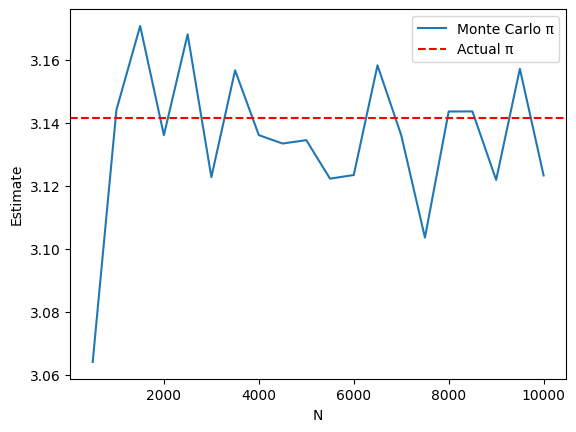

In [31]:
import random
import matplotlib.pyplot as plt

# 1. Monte Carlo π estimation
def estimate_pi(N):
    inside = 0
    for _ in range(N):
        x, y = random.uniform(-1,1), random.uniform(-1,1)
        if x**2 + y**2 <= 1:
            inside += 1
    return 4 * inside / N

# Convergence plot
def convergence_plot(maxN=10000, step=500):
    estimates = []
    trials = range(step, maxN+1, step)
    for n in trials:
        estimates.append(estimate_pi(n))
    plt.plot(trials, estimates, label="Monte Carlo π")
    plt.axhline(np.pi, color="r", linestyle="--", label="Actual π")
    plt.xlabel("N")
    plt.ylabel("Estimate")
    plt.legend()
    plt.show()

# Example usage
print(estimate_pi(10000))  # Estimate of π with 10000 samples
convergence_plot(10000, 500)  # Plot convergence up to 10000 samples

In [32]:
# 2. Chemistry-inspired Monte Carlo
def simulate_collisions(M, threshold=5.0, distribution="uniform"):
    exceed = 0
    energies = []
    for _ in range(M):
        if distribution == "uniform":
            e = random.uniform(0, 10)
        else:
            e = random.gauss(5, 2)
        energies.append(e)
        if e > threshold:
            exceed += 1
    return exceed / M, energies

# Example usage
prob_uniform, energies_uniform = simulate_collisions(10000, distribution="uniform")  # Probability with uniform distribution
prob_gauss, energies_gauss = simulate_collisions(10000, distribution="gauss")      # Probability with Gaussian distribution